In [1]:
import numpy as np
import threading
import time, os, json
import cv2
import matplotlib.pyplot as plt
import multiprocessing as mp

from scipy import stats
from situtils import FPSTimes

In [9]:
class PositionTracker(FPSTimes):

    default_cfg = {
        "background_light": "background_light.png",
        "background_dark": "background_dark.png",
        "threshold_light": 40,
        "threshold_dark": 20,
        "arena_x": 522,
        "arena_y": 372,
        "arena_radius": 330,
        "floor_radius": 287,
        "max_fps": 50,
        "file_path": "positions.csv",
        "contour_path": "contours.csv",
        "floor_r_in_meters": 0.46,
        "angle_compensation": -90,
        "flip_x": True,
        "flip_y": False
    }
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTracker, self).__init__()
        
        self.status = status
        self.cfg = cfg
        self.video_stream = video_stream
        self.bg_light = cv2.imread(cfg['background_light'], 1)
        self.bg_dark  = cv2.imread(cfg['background_dark'], 1)
        self.background = self.bg_light  # light by default
        self.is_light = True
        self._x, self._y = None, None
        self.pixel_size = cfg['floor_r_in_meters'] / float(cfg['floor_radius'])
        self.contour = []
        self.lr = None  # linear regression of the contour
        self.stopped = False

        self.mask = np.zeros(shape=self.background.shape, dtype="uint8")
        cv2.circle(self.mask, (cfg['arena_x'], cfg['arena_y']), cfg['arena_radius'], (255,255,255), -1)

        with open(cfg['file_path'], 'w') as f:
            f.write("time,x,y\n")
        with open(cfg['contour_path'], 'w') as f:
            f.write("x:y,...\n")

    def reload_background(self):
        self.bg_light = cv2.imread(self.cfg['background_light'], 1)
        self.bg_dark  = cv2.imread(self.cfg['background_dark'], 1)
        self.background = self.bg_light if self.is_light else self.bg_dark
        print('Position tracker - background reloaded')
        
    def px_to_meters(self, x, y):
        x_m = float(self.cfg['arena_x'] - x) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y_m = float(self.cfg['arena_y'] - y) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        return x_m, y_m

    def meters_to_px(self, x, y):
        x_m = self.cfg['arena_x'] - (x / self.pixel_size) * (-1 if self.cfg['flip_x'] else 1)
        y_m = self.cfg['arena_y'] - (y / self.pixel_size) * (-1 if self.cfg['flip_y'] else 1)
        return int(x_m), int(y_m)

    def correct_angle(self, phi):
        return (2*np.pi - phi) + np.deg2rad(self.cfg['angle_compensation'])
    
    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        self._th.join()
        print('Position tracker stopped')
        
    def update(self):
        next_frame = time.time() + 1.0/self.cfg['max_fps']
        
        while not self.stopped:
            frame = self.video_stream.read()
            if frame is None:
                time.sleep(0.05)
                continue
                
            if time.time() < next_frame:
                time.sleep(0.001)
                continue
                
            self.count()  # count FPS
            self.detect_position(frame)
            next_frame += 1.0/self.cfg['max_fps']

            if self.status.value == 2 and self._x is not None:
                # save position
                with open(self.cfg['file_path'], 'a') as f:
                    f.write(",".join([str(x) for x in (self.frame_times[-1], \
                               round(self.x_in_m, 4), round(self.y_in_m, 4))]) + "\n")         
                    
                # save contours
                if not len(self.contour) > 0:
                    print('No contours')
                    continue
                ctr_in_m = np.array([self.px_to_meters(x, y) for x, y in zip(self.contour[:, 0, 0], self.contour[:, 0, 1])])
                data = ["%.4f:%4f" % (x[0], x[1]) for x in ctr_in_m]
                with open(self.cfg['contour_path'], 'a+') as f:    
                    f.write(",".join(data) + "\n")                   
       
    def switch_background(self):
        self.background = self.bg_dark if self.is_light else self.bg_light 
        self.is_light = not self.is_light
        
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame or takes absdiff
        if 'subtract' in self.cfg:
            if self.cfg['subtract'] > 0:
                subject = cv2.subtract(self.background, masked_frame)
            else:
                subject = cv2.subtract(self.background, masked_frame)
        else:
            subject = cv2.absdiff(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        th = self.cfg['threshold_light'] if self.is_light else self.cfg['threshold_dark']
        _, thresh = cv2.threshold(frame_blur, th, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        self._x = M['m10'] / M['m00']
        self._y = M['m01'] / M['m00']
        self.contour = contour  # in pixels
        
        ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])
        if ctr_in_px[:, 0].max() - ctr_in_px[:, 0].min() > ctr_in_px[:, 1].max() - ctr_in_px[:, 1].min():
            slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 0], ctr_in_px[:, 1])
            self.lr = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 1], ctr_in_px[:, 0])
            self.lr = {'slope': 1 - slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
            
    @property
    def x_in_px(self):
        return int(self._x) if self._x is not None else None

    @property
    def y_in_px(self):
        return int(self._y) if self._y is not None else None
    
    @property
    def x_in_m(self):
        if self._x is None:
            return None
        return (self.cfg['arena_x'] - self._x) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
    
    @property
    def y_in_m(self):
        if self._y is None:
            return None
        return (self.cfg['arena_y'] - self._y) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)    

### Testing position detection

In [8]:
#import nbimporter
#from camera import WebcamStream

with open(os.path.join('..', 'profiles', 'andrey_hippoSIT_008228_SL_train.json')) as json_file:
    cfg = json.load(json_file)

# controller status: 1 - detecting, 2 - detecting + logging
status = mp.Value('i', 1)

# let's use a webcam stream
vs = WebcamStream(cfg['camera'])
vs.start()  # stream runs in a separate thread

# init controller
pt_cfg = cfg['position']
pt_cfg['background_light'] = os.path.join('..', 'assets', 'background_light.png')
pt_cfg['background_dark'] = os.path.join('..', 'assets', 'background_dark.png')
pt = PositionTracker(status, vs, pt_cfg)
pt.start()
kernel_size = (25,25)

try:
    while True:
        frame = vs.read()
        if frame is not None:
            masked_frame = cv2.bitwise_and(src1=frame, src2=pt.mask)
            #masked_frame = cv2.absdiff(masked_frame, pt.background)
            #masked_frame = cv2.subtract(pt.background, masked_frame)
            #masked_frame = cv2.subtract(masked_frame, pt.background)
            #masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
            #masked_frame = cv2.GaussianBlur(masked_frame, kernel_size, 0)
            
            cv2.putText(masked_frame, 'Position: %.2f FPS' % pt.get_avg_fps(), 
                     (10, 60), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))        
            
            if pt.x_in_px is not None:
                color = (127, 255, 0) if status.value == 1 else (0, 0, 255)
                cv2.circle(masked_frame, (pt.x_in_px, pt.y_in_px), 2, color, -1)
                cv2.drawContours(masked_frame, [pt.contour], 0, color, 1, cv2.LINE_AA)
                cv2.putText(masked_frame, 'Animal: %.3f %.3f' % (pt.x_in_m, pt.y_in_m), (10, 40), \
                            cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
            
                # regression line
                if pt.lr is not None:
                    x1, x2 = pt.contour[:, 0, 0].min() - 10, pt.contour[:, 0, 0].max() + 10
                    y1, y2 = int(x1 * pt.lr['slope'] + pt.lr['intercept']), int(x2 * pt.lr['slope'] + pt.lr['intercept'])
                    cv2.line(frame, (x1, y1), (x2, y2), color, 1)
            
            cv2.putText(masked_frame, 'L' if pt.is_light else 'D', (10, 20), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))            
            cv2.imshow('Webcam', masked_frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
            
        if k == ord('s'):
            status.value = 2 if status.value == 1 else 1

        if k == ord('d'):
            pt.switch_background()
            
        if k == ord('r'):
            cv2.imwrite('frame.jpg', masked_frame)
            
finally:
    cv2.destroyAllWindows()
    vs.stop(), pt.stop()

Webcam stream 1024.0:768.0 at 25.00 FPS started
Camera released
Position tracker stopped


### Image sandbox

In [5]:
image = cv2.imread('substract.jpg')
#plt.imshow(image)

In [ ]:
image[0][0]

In [ ]:
color = ('b','g','r')
for channel, col in enumerate(color):
    histr = cv2.calcHist([image],[channel],None,[256],[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0,256])
    plt.ylim([0, 1000])

## Contour test

In [ ]:
x, y = contour[0][0][0], contour[0][0][1]
pt.px_to_meters(x, y), len(contour)

In [ ]:
ctr_in_m = np.array([pt.px_to_meters(x, y) for x, y in zip(contour[:, 0, 0], contour[:, 0, 1])])
ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

x = ctr_in_px[:, 0]
y = ctr_in_px[:, 1]

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_line = np.linspace(x.min(), x.max(), 10)
y_line = x_line * slope + intercept

plt.scatter(x, y)
plt.plot(x_line, y_line)

In [5]:
filename = 'D:\\runSIT\\sessions\\52_aSIT_2021-11-15_11-12-00\\contours.csv'
with open(filename) as ff:
    data = ff.readlines()

headers = data[0]   # skip headers line
contours = [[(float(x.split(':')[0]), float(x.split(':')[1])) for x in contour.split(',')] for contour in data[1:]]
contours = [np.array(contour) for contour in contours]

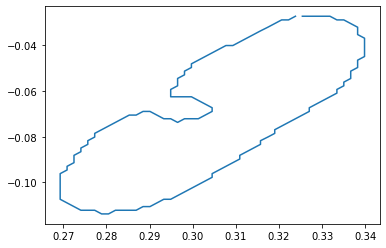

In [8]:
plt.plot(contours[0][:, 0], contours[0][:, 1])